In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from random import randint
from ipywidgets import interact
from IPython.display import display
import ipywidgets as widgets
import subprocess
%matplotlib inline

In [14]:
G = nx.Graph()
with open('graph.txt', 'r') as f:
    n, m = map(int, f.readline().strip().split())
    G.add_nodes_from(range(n))
    for _ in range(m):
        u, v = map(int, f.readline().strip().split())
        G.add_edge(u, v)
W, H = 100, 100

In [34]:
layouts = [{i: (randint(0, W), randint(0, H)) for i in G} for _ in range(1)]
meta = []
temperature = []

In [16]:
with open('start.txt', 'r') as f:
    last = None
    for line in f:
        last = line
    layouts = [{i : tuple(map(float, x.split())) for i, x in enumerate(last.split(';')[:len(G)])}]

In [45]:
nodesW = widgets.FloatLogSlider(description='Nodes', min=0, max=3, value=1000)
borderW = widgets.FloatLogSlider(description='Border', min=0, max=3, value=1000)
edgesW = widgets.FloatLogSlider(description='Edges', min=-3, max=0, value=0.01)
crossW = widgets.FloatLogSlider(description='Crossings', min=0, max=4, value=300)
T = widgets.FloatLogSlider(description='Temperature', min=0, max=5, value=1e4)
cooling = widgets.Text(description='Cooling', value='0.9985')
iters = widgets.IntSlider(description='Iterations', min=1, max=100000, value=10000)
button = widgets.Button(description='Launch annealing')
tune = widgets.Button(description='Launch fine tuning')

def launch_annealing(button):
    try:
        float(cooling.value)
    except:
        print('Cooling temperature (%s) is incorrect' % cooling.value)
        return
    with open('start.txt', 'w') as f:
        f.write(';'.join(map(lambda x: "%s %s" % (x[0], x[1]), (layouts[-1][i] for i in sorted(list(G.nodes))))))
    new_info = subprocess.run([
        "./build/main",
        "--nodes", str(nodesW.value),
        "--edges", str(edgesW.value),
        "--border", str(borderW.value),
        "--cross", str(crossW.value),
        "--startT", str(T.value),
        "--cooling", str(cooling.value),
        "--rounds", str(iters.value),
        "--width", str(W),
        "--height", str(H),
        "--starting-layout", "start.txt"
    ], capture_output=True).stdout.decode('utf-8').split('\n')
    temp = T.value
    for line in new_info:
        coords = dict(enumerate(map(lambda x: tuple(map(float, x.split(' '))), line.split(';')[:-4])))
        if len(coords) > 0:
            layouts.append(coords)
            meta.append(tuple(map(float, line.split(';')[-4:])))
            temperature.append(temp)
            temp *= float(cooling.value)
    print('EndT=%f; Added %d new layouts, now history contains %d layouts' % (temp, len(new_info), len(layouts)))
    
def fine_tune(button):
    try:
        float(cooling.value)
    except:
        print('Cooling temperature (%s) is incorrect' % cooling.value)
        return
    with open('start.txt', 'w') as f:
        f.write(';'.join(map(lambda x: "%s %s" % (x[0], x[1]), (layouts[-1][i] for i in sorted(list(G.nodes))))))
    new_info = subprocess.run([
        "./build/main",
        "--nodes", str(nodesW.value),
        "--edges", str(edgesW.value),
        "--border", str(borderW.value),
        "--cross", str(crossW.value),
        "--startT", str(T.value),
        "--cooling", str(cooling.value),
        "--rounds", str(iters.value),
        "--width", str(W),
        "--height", str(H),
        "--fine-tune",
        "--starting-layout", "start.txt"
    ], capture_output=True).stdout.decode('utf-8').split('\n')
    temp = T.value
    for line in new_info:
        coords = dict(enumerate(map(lambda x: tuple(map(float, x.split(' '))), line.split(';')[:-4])))
        if len(coords) > 0:
            layouts.append(coords)
            meta.append(tuple(map(float, line.split(';')[-4:])))
            temperature.append(temp)
    print('EndT=%f; Added %d new layouts, now history contains %d layouts' % (temp, len(new_info), len(layouts)))

def do_reset(button):
    W, H = 100, 100
    global layouts
    global meta
    global temperature
    layouts = layouts[:1]
    meta = []
    temperature = []
    print('Resetting: now have %d layouts' % len(layouts))
    
display(nodesW)
display(borderW)
display(edgesW)
display(crossW)
display(T)
display(cooling)
display(iters)
display(button)
display(tune)
button.on_click(launch_annealing)
tune.on_click(fine_tune)
reset = widgets.Button(description='Reset')
display(reset)
reset.on_click(do_reset)
print('History contains %d layouts' % len(layouts))

FloatLogSlider(value=1000.0, description='Nodes', max=3.0)

FloatLogSlider(value=1000.0, description='Border', max=3.0)

FloatLogSlider(value=0.01, description='Edges', max=0.0, min=-3.0)

FloatLogSlider(value=300.0, description='Crossings')

FloatLogSlider(value=10000.0, description='Temperature', max=5.0)

Text(value='0.9985', description='Cooling')

IntSlider(value=10000, description='Iterations', max=100000, min=1)

Button(description='Launch annealing', style=ButtonStyle())

Button(description='Launch fine tuning', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

History contains 100002 layouts
Resetting: now have 1 layouts
EndT=0.003020; Added 10002 new layouts, now history contains 10002 layouts
EndT=0.000000; Added 100002 new layouts, now history contains 110003 layouts
EndT=10000.000000; Added 100002 new layouts, now history contains 210004 layouts


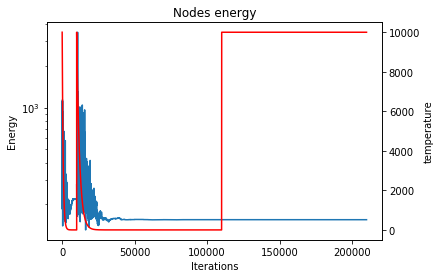

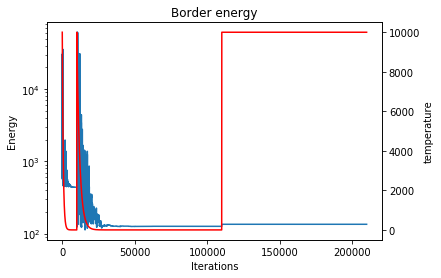

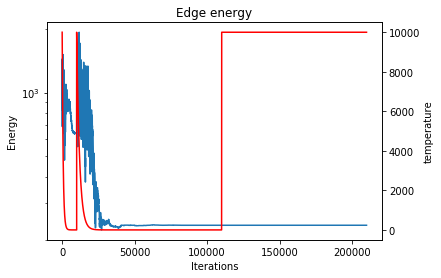

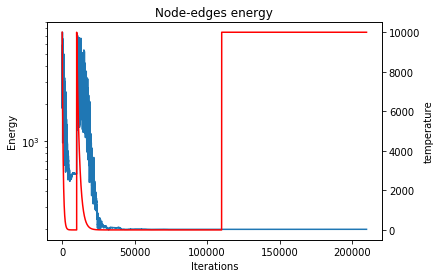

In [50]:
titles = ['Nodes energy', 'Border energy', 'Edge energy', 'Node-edges energy']
for i in range(4):
    fig, ax1 = plt.subplots()
    ax1.semilogy(range(len(meta)), [x[i] for x in meta])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Energy')
    ax2 = ax1.twinx()
    ax2.plot(range(len(temperature)), temperature, c='r')
    ax2.set_ylabel('temperature')
    plt.title(titles[i])
    plt.show()

In [51]:
def draw(t):
    nx.draw(G, pos=layouts[t], with_labels=True)
    plt.xlim(0, W)
    plt.ylim(0, H)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.axhline(H, color='black')
    plt.axvline(W, color='black')
    plt.show()
it = interact(draw, t=widgets.IntSlider(min=0,max=len(layouts)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='t', max=210003), Output()), _dom_classes=('widget-intera…